In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import ndimage
%matplotlib notebook

In [96]:
class make_terrain():
    
    def __init__(self, size):
        self.size = size
        self.mapa = np.zeros([self.size, self.size])
        self.okean = np.zeros([self.size, self.size])
        self.rivers = []
        self.coast = []
        self.trigger = True
        
    def insert_blob(self, i, j, radius, heightsigma):
        for di, dj in self.didj_circle(radius):
            outer = ((di**2+dj**2)+1.0)/radius**2
            self.mapa[(i+di)%self.size,(j+dj)%self.size] += (heightsigma*((1-outer))/2 * np.random.exponential())
    
    def add_smooth_blob(self,i,j, radius, suma):
        k = radius
        a = np.zeros([2*k+1,2*k+1])
        a[k, k] = suma
        a = ndimage.gaussian_filter(a,k/2)
        blobsize = 2*k+1
        for i1 in range(blobsize):
            for j1 in range(blobsize):
                if (i-k+i1>=0) and (j-k+j1>0) and (i-k+i1<self.size) and (j-k+j1<self.size):
                    self.mapa[i-k+i1, j-k+j1] += a[i1,j1]
        
    def low_outside(self):
        a = np.zeros([self.size,self.size])
        k = int(self.size/2)
        a[k, k] = self.size**2
        a = ndimage.gaussian_filter(a,0.75*k)
        self.mapa = self.mapa*a
        
    def islands_v1(self, n, scale):
        
        island_sizes = np.random.exponential(scale = scale, size = n)
        
        for i in range(n):
            size = island_sizes[i]
            heightsigma = island_sizes[i]
            self.insert_blob(np.random.choice(self.size-1), np.random.choice(self.size-1), 
                             size, heightsigma)
        
    def islands_v2(self, n, scale):
        island_sizes = np.random.exponential(scale = scale, size = n)
        for i in range(n):
            size = island_sizes[i]
            self.add_smooth_blob(np.random.choice(self.size-1), np.random.choice(self.size-1),
                                 int(size), size**2)
        
    def didj_circle(self, r):
        d = int(r)
        exit = []
        for i in range(-d,d+1):
            for j in range(-d,d+1):
                if (i**2+j**2<d**2):
                    exit.append([i,j])
        return exit
    
    def didj_square(self, r):
        d = int(r)
        exit = []
        for i in range(-d,d+1):
            for j in range(-d,d+1):
                exit.append([i,j])
        return exit
    def minijmaxij(self, i,j,rad):
        mini = max(i-rad,0) 
        maxi = min(i+rad+1,self.size)
        minj = max(j-rad,0)
        maxj = min(j+rad+1,self.size)
        return mini, maxi, minj, maxj
    
    def smooth(self, sigma):
        self.mapa = ndimage.gaussian_filter(self.mapa, sigma)
    
    def local_smooth(self,i,j,rad):
        mini,maxi,minj,maxj = self.minijmaxij(i,j,rad)
        self.mapa[mini:maxi,minj:maxj]= ndimage.gaussian_filter(self.mapa[mini:maxi,minj:maxj],1)
    
    def normalize(self):
        s = sum(self.mapa)
        self.mapa = self.mapa/s
    
    def mean_value(self):
        return np.average(self.mapa)
    
    def random_river(self,vers, rad,add):
        i,j = np.random.choice(self.size-1),np.random.choice(self.size-1)
        return self.river(i,j,vers,rad,add)
    
    def river(self,i,j,vers, rad, add):
        river = []
        river.append([i,j])
        while (not self.okean[i,j]) and  i>0 and i<self.size-1 and j>0 and j<self.size-1:
            #print(i,j)
            if vers == 1:
                i,j = self.river_flow(i,j,rad,add)
            elif vers == 2:
                i,j = self.river_flow_v2(i,j)
            else: print("no such version")
            river.append([i,j])
        if len(river)>1:
            self.rivers.append(river)
        return river
        
    def river_flow(self,i,j,rad,add):
        while True:
            mini,minj,minh = i-1,j-1,self.mapa[i-1,j-1]
            for di,dj in self.didj_square(1):
                if self.mapa[i+di,j+dj]<minh:
                    mini,minj, minh = i+di,j+dj,self.mapa[i+di,j+dj]
            if not(mini==i and minj==j):
                return mini, minj
            else:
                self.add_smooth_blob(i,j, rad, add)
    
    def river_flow_v2(self,i,j):
        while True:
            
            print("i,j",i,j)
            
            minh = self.mapa[i,j]
            
            print("minh ", minh)
            
            k=1
            mini,maxi,minj,maxj = self.minijmaxij(i,j,k)
            print("minimaxi:", mini, maxi, minj, maxj)
            
            if (self.mapa[mini:maxi, minj:maxj]<minh).any():
                
                minh = np.min(self.mapa[mini:maxi, minj:maxj])
                print("new minh ", minh)
                c = np.where((self.mapa[mini:maxi, minj:maxj]==minh))
                print(c)
                print(c[0][0], c[1][0])
                
                return c[0][0]+mini, c[1][0]+minj
            
            else:
                k += 1
                print(k)
        
            
    
    def erode(self, n_rivers, vers, riverrad, riveradd):
        
        for k in range(n_rivers):
            print("     ",k, end="\r")
            for i,j in self.random_river(vers, riverrad, riveradd):
                self.mapa[i,j] *=0.9
                self.local_smooth(i,j,riverrad)
                if len(self.rivers)>1000:
                    self.rivers = self.rivers[-100:]
        
        
    def flatten_sharps(self, m):
        self.mapa = np.where(self.mapa>m, m+(self.mapa-m)/2, self.mapa)
    
    
        """def coast(self):
        m = self.mean_value()
        continent = self.mapa>m
        
        return """
    def set_ocean(self):
        zero = self.mean_value()
        self.mapa = self.mapa-zero
        self.okean = self.mapa<0
        for i in range(5):
            self.smooth_coast()
    def smooth_coast(self):
        self.okean = ndimage.morphology.binary_erosion(self.okean)
    def set_coast(self,h):
        self.coast= []
        candidates = np.where(self.mapa>h)
        for i,j in zip(candidates[0],candidates[1]):
            mini,maxi,minj,maxj = self.minijmaxij(i,j,1)
            if (self.mapa[mini:maxi,minj:maxj]<h).any():
                self.coast.append((i,j))
                if self.trigger:
                    print(self.mapa[mini:maxi,minj:maxj])
                    self.trigger = False
    def reset_rivers(self):
        self.rivers = []
    def add_vp(self,n,p,rad,rad_mount,suma):
        for i in range(n):
            i,j,k,l=np.random.choice(self.size),np.random.choice(self.size),np.random.choice(self.size),np.random.choice(self.size)
            self.vatreni_pojas(i,j,k,l,p,rad,rad_mount,suma)
    def vatreni_pojas(self,i1,j1,i2,j2, p, rad, radius_mount, suma):
        for i,j in self.linija(i1,j1,i2,j2):
            if(np.random.uniform()<p):
                di,dj = np.random.choice(rad-1),np.random.choice(rad-1)
                self.add_smooth_blob(i+di,j+dj, radius_mount, suma)
                    
    def linija(self,i1,j1,i2,j2):
        exit = []
        if i1!=i2:
            coef = (j2-j1)/(i2-i1)
            const = j1-i1*coef
            for i in range(i1,i2):
                j=int(i*coef+const+min(abs(i1-i),abs(i2-i))/3)
                exit.append((i,j))
        else:
            for j in range(j1,j2):
                i = int(i1+min(abs(j1-j),abs(j2-j))/3)
                exit.append((i,j))
        return exit
        

In [97]:
%%time
n=400
minos = make_terrain(n)

Wall time: 0 ns


In [98]:
minos.islands_v1(n, scale = int(np.sqrt(n)))
minos.normalize()
minos.mapa = minos.mapa*n

In [99]:
minos.smooth(1)

In [100]:
#minos.flatten_sharps()

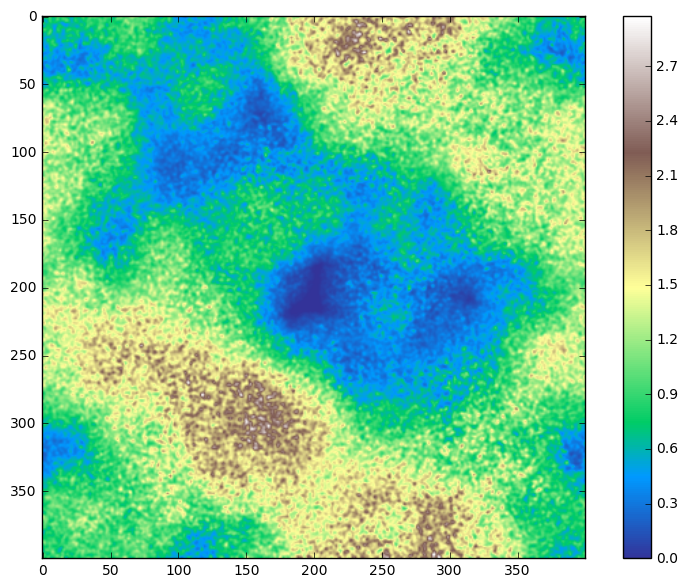

In [101]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,7))
a = ax.imshow(minos.mapa, cmap = "terrain") #[200:300,200:300]
#plt.imshow(ndimage.morphology.grey_erosion(minos.coast(), size=(1,1)))
#plt.scatter([x[1] for x in r], [x[0] for x in r], color = "r", s = 1)
plt.colorbar(mappable=a)
plt.show()

In [102]:
%%time
minos.islands_v2(n,scale = np.sqrt(n))

Wall time: 3.38 s


In [103]:
#small amout of huge mountains
minos.add_vp(int(np.sqrt(np.sqrt(n))), 1, 2*int(np.sqrt(n)), int(np.sqrt(n)),int(np.sqrt(n)))
#large amount of small mountains
minos.add_vp(n,1,20,5, 5)

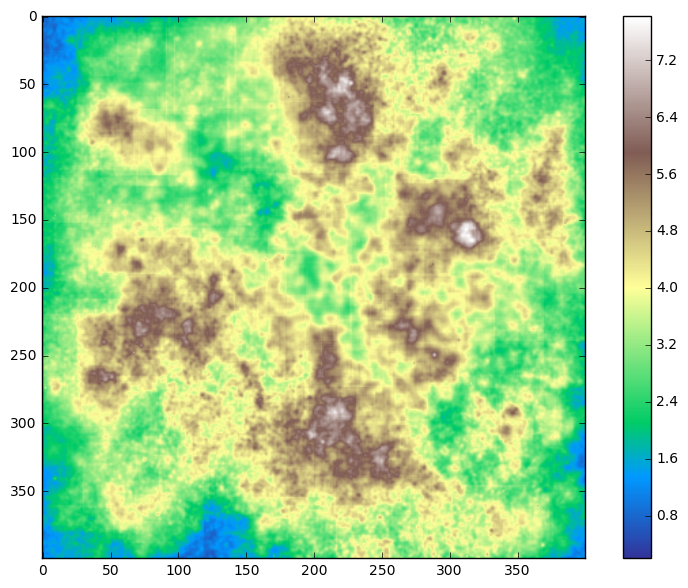

In [104]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,7))
a = ax.imshow(minos.mapa, cmap = "terrain", ) #[200:300,200:300]
#plt.imshow(ndimage.morphology.grey_erosion(minos.coast(), size=(1,1)))
plt.colorbar(mappable=a)
plt.show()

In [105]:
%%time
for i in range(3):
    minos.low_outside()

Wall time: 974 ms


In [106]:
minos.flatten_sharps(8)

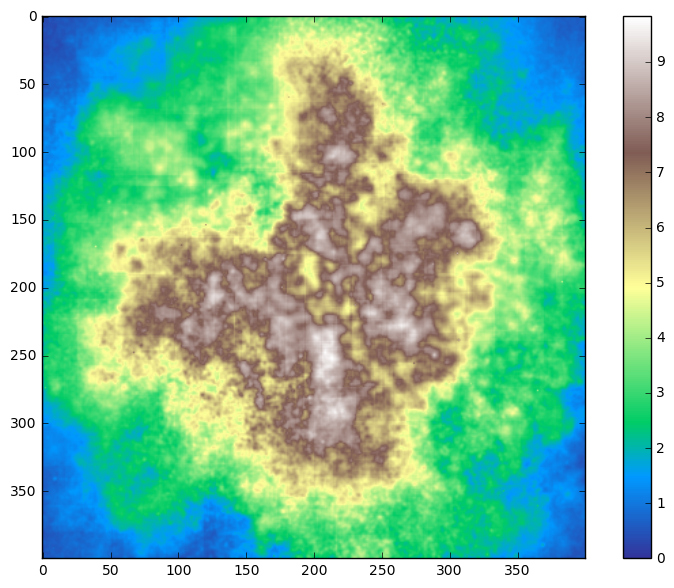

In [107]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,7))
a = ax.imshow(minos.mapa, cmap = "terrain", vmin=0) #[200:300,200:300]
#plt.imshow(ndimage.morphology.grey_erosion(minos.coast(), size=(1,1)), )
plt.colorbar(mappable=a)
plt.show()

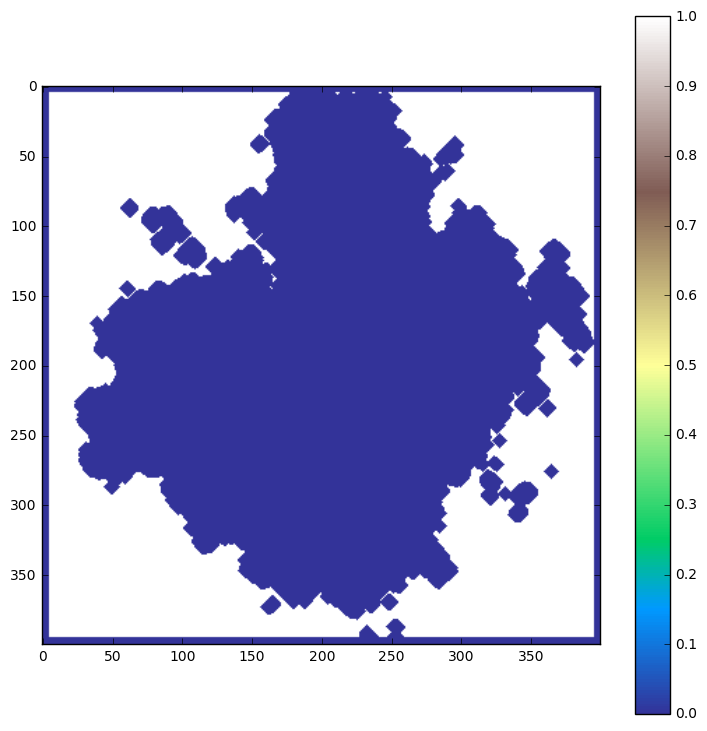

In [108]:
%matplotlib inline
minos.set_ocean()
fig, ax = plt.subplots(figsize = (9,9))
a = ax.imshow(minos.okean, cmap = "terrain") #[200:300,200:300]
#plt.imshow(ndimage.morphology.grey_erosion(minos.coast(), size=(1,1)))
#r = minos.rivers
#plt.scatter([x[1] for x in r], [x[0] for x in r], color = "r", s = 1)
plt.colorbar(mappable=a)
#plt.show()

In [ ]:
%%time
minos.reset_rivers()
minos.erode(10,2,1,1)
print("done")

i,j 117 313
minh  0.0293712911613
minimaxi: 116 119 312 315
new minh  -0.241215258781
(array([0], dtype=int64), array([0], dtype=int64))
0 0
i,j 116 312
minh  -0.241215258781
minimaxi: 115 118 311 314
new minh  -0.267515333529
(array([1], dtype=int64), array([0], dtype=int64))
1 0
i,j 116 311
minh  -0.267515333529
minimaxi: 115 118 310 313
new minh  -0.31181526473
(array([1], dtype=int64), array([0], dtype=int64))
1 0
i,j 116 310
minh  -0.31181526473
minimaxi: 115 118 309 312
2
i,j 116 310
minh  -0.31181526473
minimaxi: 115 118 309 312
2
i,j 116 310
minh  -0.31181526473
minimaxi: 115 118 309 312
2
i,j 116 310
minh  -0.31181526473
minimaxi: 115 118 309 312
2
i,j 116 310
minh  -0.31181526473
minimaxi: 115 118 309 312
2
i,j 116 310
minh  -0.31181526473
minimaxi: 115 118 309 312
2
i,j 116 310
minh  -0.31181526473
minimaxi: 115 118 309 312
2
i,j 116 310
minh  -0.31181526473
minimaxi: 115 118 309 312
2
i,j 116 310
minh  -0.31181526473
minimaxi: 115 118 309 312
2
i,j 116 310
minh  -0.31181526

In [ ]:
#r=minos.river(150,200,1,1)
len(minos.rivers)

In [81]:
minos.rivers

[]

In [17]:
#for i,j in r:
#    minos.mapa[i,j] = minos.mapa[i,j]/2

In [18]:
#river = minos.river(630,400,1,1)

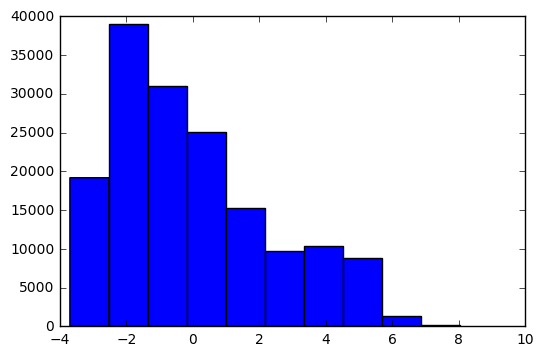

In [19]:
plt.hist(minos.mapa.flatten())
plt.show()

In [20]:
minos.mean_value()
#minos.didj_square(1)

5.3792299252108931e-07

In [21]:
minos.set_coast(0)

[[-0.3627477  -0.22816931 -0.22670991]
 [-0.09207201  0.00693895  0.03107014]
 [ 0.15007036  0.19383319  0.20661814]]


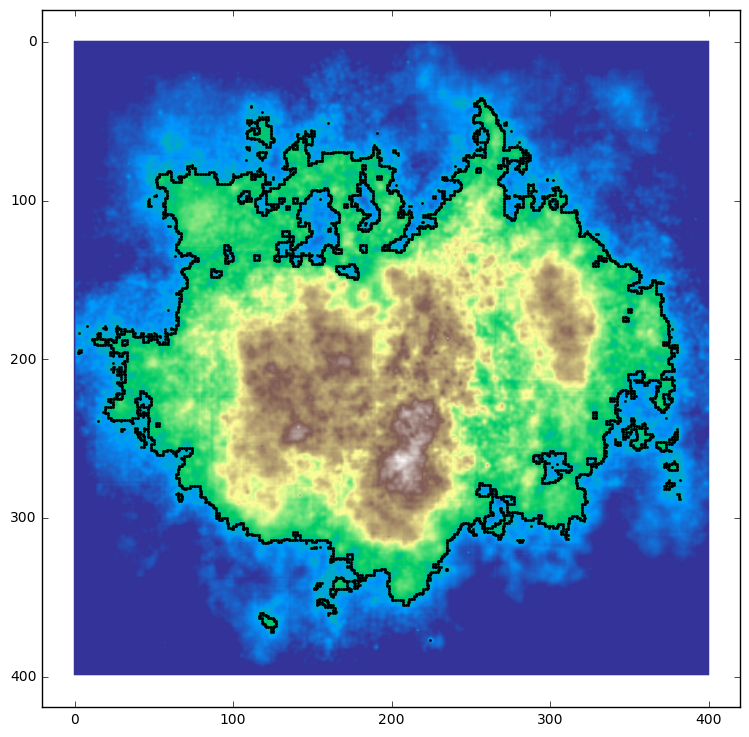

In [22]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (9,9))
for r in minos.rivers:
    #r = river #minos.rivers[-10000:]
    plt.plot([x[1] for x in r], [x[0] for x in r], color = "blue")
a = ax.imshow(minos.mapa, cmap = "terrain",vmin = -2) #[200:300,200:300]
c= minos.coast
plt.scatter([x[1] for x in c], [x[0] for x in c], color = "black",s = 1)
#plt.imshow(ndimage.morphology.grey_erosion(minos.coast(), size=(1,1)))

#plt.colorbar(mappable=a)
#ax.set_xlim(100,120)
#ax.set_ylim(60,40)
plt.show()

def smooth_blob(k, suma):
    a = np.zeros([2*k+1,2*k+1])
    a[k, k] = suma
    a = ndimage.gaussian_filter(a,0.75*k)
    return a

print(smooth_blob(250,250*250).shape)
a = plt.imshow(smooth_blob(250,250*250))
plt.colorbar(mappable=a)
plt.show()

print(np.sum(smooth_blob(1))

np.save("minos1", minos.mapa)

np.load("minos1.npy")

In [23]:
#np.where(minos.mapa>1)

In [24]:
#np.min(minos.mapa)